# XGBoost model

In this notebook we will create a model using XGBoost to model our banking marketing data set. The aim of the model wil be to rank the customers of the bank in terms of how likely they are to subscribe to a term deposit. Essentially we will be able to obtain two probability distribution functions, one for the customers who subscribe and for those who do not. 

The metric which we will use is the area under the curve of the ROC, this is in line with the research paper which this data set was obtained from. The AUC is a good metric for this data set since the data set is quite unbalanced, since it has a success rate of only 11.7%. Additionally using the same metric as the research papers allows us to compare our results to their's and measure how well we are doing.

## Import libaries and data set

In [658]:
import pandas as pd
import graphviz
from xgboost import plot_tree
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
%matplotlib inline

In [659]:
# Start by importing the data
bank = pd.read_csv('bank-full2.csv', delimiter=',')

## Data cleaning and preparation

To clean this data we will:
    - Drop the rows of our data set where the job is unknown, since we saw in our EDA the average of the group is almost the same as our data set, and there is only 288 rows, it is resonable to drop the rows
    - Encode our categorical data using a lable encoder

In [660]:
# We drop the 288 rows where the job is unknown
bank = bank.drop(bank[bank.job=='unknown'].index)

In [661]:
# We'll clean up the data a bit by encoding the categories using a label encoder
lb_make = LabelEncoder()

categories = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'y']
for col in categories: 
    bank[str(col)+"_code"] = lb_make.fit_transform(bank[col])    

## Feature engineering 

There are a number of features which I found which improved the performance of the model, they are:
    - The date
    - The difference between the CPI and the term deposit rate
    - The level of unemployment
    - The CPI
    - The change in the monthly unemployment rate between the current and previous month

Until now Data Scientists modeling this data set have used a feature numbering the day of the month, and the month, looking at previous research it appears that these features are statistically significant. However the problem with the current approach is that it misses the bigger picture, the data set represents a marketing campaign which was conducted over a three year period. Thus it is naive to treat days and months as if they were homogenous, e.g. it is naive to say that July 2008 is equivalent to July 2010. There are no doubt social and economic factors which are affecting the consumers behaviour, since these factors are constantly changing it made sense to add in a date variable.

Another factor which had a large affect on the performance of the model was the addition of a feature which captured the difference between the Portugese Consumer Price Index and the Portugese three month term deposit rate. The rational behind this feature is that customers are rational, rather than looking at the aggregate rate (i.e. the term deposit rate) they are concerned with the real rate of return, meaning the difference between the term deposit rate and the CPI.

The final three feature I have included are the level of unemployment, CPI, and the change in the monthly unemployment rate between the current and previous month. These features lead to modest improvements in the models performance. 

In [662]:
# We will now create a new feature called date, we do this by combining the date, month and year columns, the format I will use is DDMMYYYY
bank['month'+"_code"] = lb_make.fit_transform(bank['month'])
bank['date'] = (bank['day']*1000000)+(bank['month_code']*10000)+bank['year']

In [678]:
X = bank.drop(['y_code', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'y', 'month', 'day', 'year'],axis=1)
y = bank['y_code']

## Building the model

We start off by doing a grid search to find the best hyperparameters for our model. We then test the model using k folds cross validate, using 15 folds and 400 rounds of boosting we arrive at an AUC of 0.947, this is significantly better than the scores obtained by previous researchers. Note that the model is tested in the cross validation round using the additional paramerers subsample and colsample_bytree.  

In [552]:
gbm_param_grid = {'n_estimators': [10], 'max_depth': [5], 'learning_rate': [0.08], "subsample": [0.1], "colsample_bytree": [0.95]}

gbm = xgb.XGBClassifier()

grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, scoring='roc_auc', cv=5)

grid_mse.fit(X, y)

print("Best parameters found: ", grid_mse.best_params_)
print("Lowest AUC found: ", np.sqrt(np.abs(grid_mse.best_score_)))


Best parameters found:  {'colsample_bytree': 0.95, 'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.1}
Lowest AUC found:  0.768310639673


In [679]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

bank_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
#bank_dmatrix = xgb.DMatrix(data=X, label=y)

In [681]:
# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"binary:logistic", "max_depth":5, "learning_rate":0.078, "subsample":0.91, "colsample_bytree":0.95}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=bank_dmatrix, params=params, nfold=15, num_boost_round=400, as_pandas=True, metrics='auc')
print(cv_results)
#results.append([cv_results["test-auc-mean"][99], test_size])

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.892591      0.012827        0.901786       0.005648
1         0.905358      0.014585        0.913556       0.007359
2         0.916013      0.011321        0.921901       0.007862
3         0.921587      0.012133        0.926797       0.006558
4         0.926888      0.013136        0.933568       0.005380
5         0.930234      0.010312        0.936383       0.003533
6         0.931908      0.009457        0.938262       0.001189
7         0.932303      0.009116        0.938842       0.001098
8         0.932698      0.009048        0.939487       0.001206
9         0.932955      0.009027        0.940087       0.001130
10        0.933436      0.009290        0.940551       0.001050
11        0.933689      0.009040        0.940959       0.001063
12        0.934387      0.009006        0.941808       0.000948
13        0.934922      0.008868        0.942403       0.000982
14        0.935432      0.008642        

In [581]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

bank_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

In [604]:
xg_cl = xgb.XGBClassifier(objective="reg:logistic", n_estimators=400, learning_rate=0.078, subsample=0.91, colsample_bytree=0.95, max_depth=5)
xg_cl.fit(X_train, y_train)
preds = xg_cl.predict_proba(X_test)

In [592]:
print(preds)
preds = pd.DataFrame(preds)
y_test = pd.DataFrame(y_test)
#preds.append(y_test)
preds.to_csv("predictions.csv")
y_test.to_csv("y_test")

[[  9.97695208e-01   2.30480940e-03]
 [  9.91589487e-01   8.41051992e-03]
 [  9.99383450e-01   6.16561272e-04]
 ..., 
 [  8.70013058e-01   1.29986957e-01]
 [  9.99288499e-01   7.11516070e-04]
 [  9.97987509e-01   2.01247097e-03]]


In [394]:
results = pd.DataFrame(columns=['Size','AUC'])

In [396]:
# Let's look at how the size of the training data affects the AUC
data_sizes = (0.995, 0.99, 0.9, 0.7, 0.5, 0.3, 0.2, 0)
llst = []

for sample in data_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=sample)
    bank_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    cv_results = xgb.cv(dtrain=bank_dmatrix, params=params, nfold=5, num_boost_round=400, as_pandas=True, metrics='auc')
    llst.append({'Size': sample, 'AUC': cv_results["test-auc-mean"][399]})

In [397]:
results.append(llst)
print(llst)

[{'Size': 0.995, 'AUC': 0.81028979999999995}, {'Size': 0.99, 'AUC': 0.90715179999999995}, {'Size': 0.9, 'AUC': 0.92681040000000015}, {'Size': 0.7, 'AUC': 0.94191599999999998}, {'Size': 0.5, 'AUC': 0.94135600000000008}, {'Size': 0.3, 'AUC': 0.94536460000000011}, {'Size': 0.2, 'AUC': 0.94588339999999993}, {'Size': 0, 'AUC': 0.94747120000000007}]


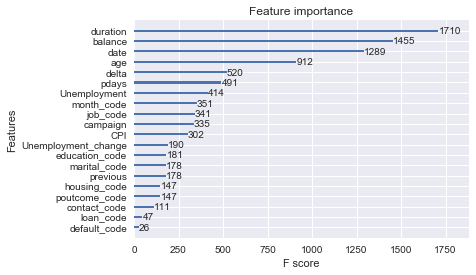

In [584]:
model = xgb.train(params=params, dtrain=bank_dmatrix, num_boost_round=400)
xgb.plot_importance(model)
plt.show()

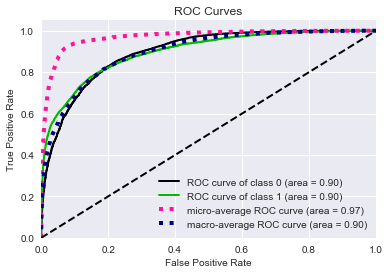

In [657]:
import scikitplot as skplt

xg_cl.fit(X, y)
probas = xg_cl.predict_proba(X)
skplt.metrics.plot_roc_curve(y_true=y, y_probas=probas)
plt.show()

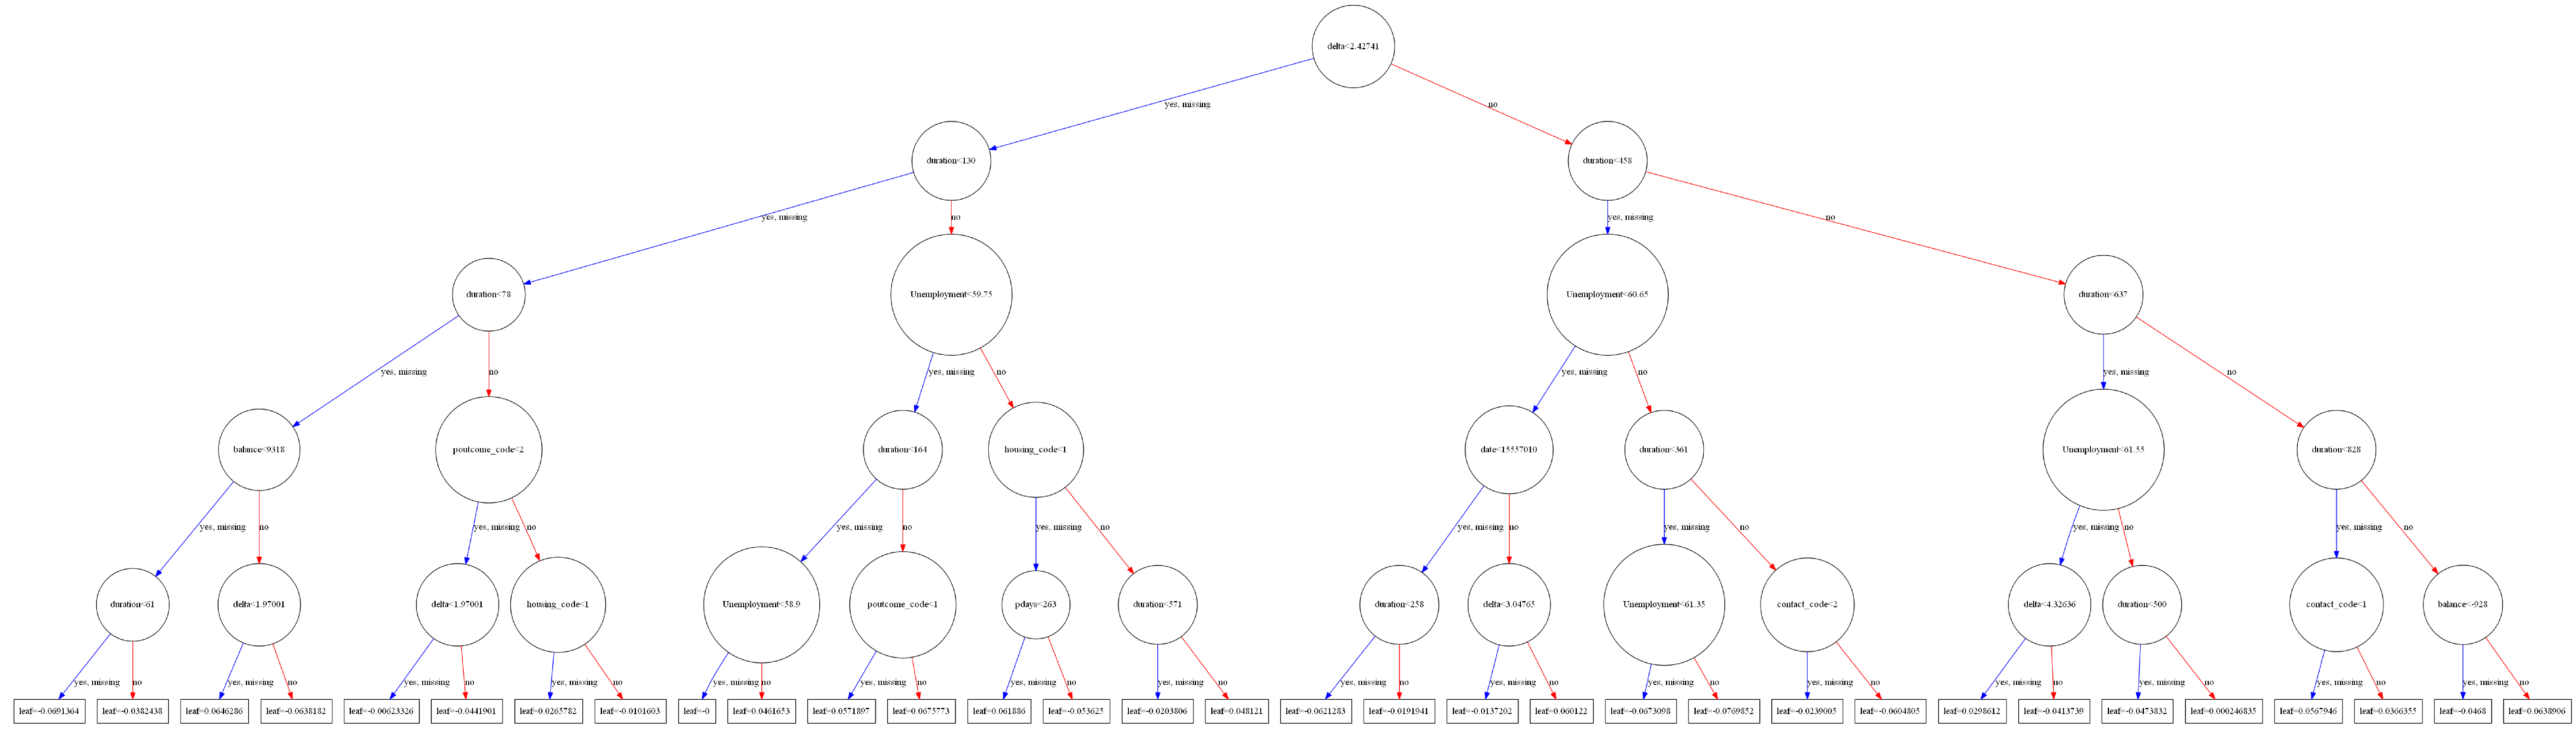

In [349]:
xgb.plot_tree(model, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')